# Imports

In [14]:
# Checa ambiente - se rodando local não usa o Google Drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [15]:
if (IN_COLAB):
    !pip install pytorch_lightning -qqq
    !pip install neptune
    from google.colab import drive 
    drive.mount('/content/gdrive')

In [16]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import neptune

In [17]:
%env NEPTUNE_ALLOW_SELF_SIGNED_CERTIFICATE='TRUE'
#run = neptune.init_run(
#    project="fabiogr/Projeto-IA901",
#   api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==")  # your credentials

env: NEPTUNE_ALLOW_SELF_SIGNED_CERTIFICATE='TRUE'


In [18]:
# Redução das mensagens de log no terminal.
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados

In [19]:
if (IN_COLAB):
    root = '/content/gdrive/MyDrive/IA901A_Projeto/data/interim/ADNI5'
else:
    root = '../../data/interim/ADNI5'

In [20]:
def setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize):
    tfList = []

    if(tfGrayscale):
        tfList.append(transforms.Grayscale(num_output_channels=3))

    if(tfRdRotate):
        tfList.append(transforms.RandomRotation(10))

    if (tfHzFlip):
        tfList.append(transforms.RandomHorizontalFlip())
        
    if (tfResize):
        tfList.append(transforms.Resize(256))

    if (tfCtrCrop):
        tfList.append(transforms.CenterCrop(224))

    tfList.append(transforms.ToTensor())

    if (tfNormalize):
        tfList.append(transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]))

    transform_lst = transforms.Compose(tfList)

    return transform_lst

In [21]:
def transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize):
    tfText = "Base"

    if(tfGrayscale):
        tfText = tfText + "+Grayscale"

    if(tfRdRotate):
        tfText = tfText + "+Random Rotation"

    if (tfHzFlip):
        tfText = tfText + "+Random Hz Flip"
        
    if (tfResize):
        tfText = tfText + "+Resize"

    if (tfCtrCrop):
        tfText = tfText + "+Center Crop"

    if (tfNormalize):
        tfText = tfText + "+Normalization"

    return tfText

In [22]:
from collections import Counter

train_dir = root + '/train'
dataset0=datasets.ImageFolder(root=train_dir,transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

print("Número de amostras por classe (train): ", dict(Counter(dataset0.targets)))

805
['AD', 'CN', 'EMCI', 'LMCI', 'MCI']
5
Número de amostras por classe (train):  {0: 151, 1: 209, 2: 179, 3: 98, 4: 168}


In [23]:
def collate_fn(batch):

    maxHeight = 0
    maxWidth = 0
    channels = 0

    for x, y in batch:

        ch, w, h = x.shape
        channels = ch

        if w > maxWidth:
            maxWidth = w
        if h > maxHeight:
            maxHeight = h

    # Now resize all images of the batch
    list_x = []
    list_y = []

    for x, y in batch:

        print("MaxHeight = " + str(maxHeight))
        print("MaxWidth = " + str(maxWidth))

        ch, w, h = x.shape
        pad_height = int((maxHeight - h)/2)
        pad_width = int((maxWidth - w)/2) 

        print("pad_height = ", str(pad_height))
        print("pad_width = ", str(pad_width))

        new_x = torch.nn.functional.pad(input=x, pad=(
                pad_height, pad_height, pad_width, pad_width), mode='constant', value=0)

        '''
        if (w != maxWidth or h != maxHeight):
            # padded tensor
            # new_x = torch.zeros([channels, maxWidth, maxHeight])
            # pad before and after to keep centralized
            pad_height = int((maxHeight - h)/2)
            pad_width = int((maxWidth - w)/2)

            new_x = torch.nn.functional.pad(input=x, pad=(
                pad_height, pad_height, pad_width, pad_width), mode='constant', value=0)
        else:
            new_x = x
        '''
        
        list_x.append(new_x)
        list_y.append(y)

    return torch.stack(list_x), torch.tensor(list_y)

In [24]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform, batch_size):
        super().__init__()
        self.root_dir = root
        self.transform = transform
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        #dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        #n_data = len(dataset)
        #n_train = int(0.7 * n_data)
        #n_val = int(0.15 * n_data)
        #n_test = n_data - (n_train + n_val)

        #train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test], generator=torch.#Generator().manual_seed(42))

        train_folder = self.root_dir + '/train'
        val_folder = self.root_dir + '/val'
        test_folder = self.root_dir + '/test'
        train_dataset = datasets.ImageFolder(root=train_folder, transform=self.transform)
        val_dataset = datasets.ImageFolder(root=val_folder, transform=self.transform)
        test_dataset = datasets.ImageFolder(root=test_folder, transform=self.transform)

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset
    
    def test_dataloader(self):
        return self.test_dataset

In [25]:
# Datamodule baseados nas transformações

batch_size = 32
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

# Vizualizando imagens

MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  0
pad_width =  3
MaxHeight = 256
MaxWidth = 176
pad_height =  0
pad_width =  3
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  8
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  0
pad_width =  3
MaxHeight = 256
MaxWidth = 176
pad_height =  32
pad_width =  8
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  32
pad_width =  8
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  0
MaxHeight = 256
MaxWidth = 176
pad_height =  8
pad_width =  8
MaxHeight = 256
MaxWidth = 176
pad_height =  32
pad_width =  8
MaxHeight = 256
MaxWidth = 176
pad_height =  32
pad_width =  8
MaxH

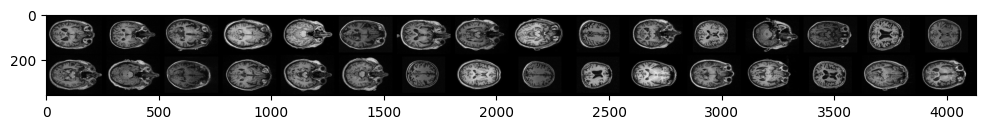

In [26]:
for images, labels in datamodule.train_dataloader():
    break

#images, labels = list(map(list, zip(*data)))

im = make_grid(images, nrow=16)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

# Definindo e treinando o modelo base: AlexNet

In [27]:
print(len(class_names))

5


## Funções para definição do modelo, treinamento, testes e métricas

In [28]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

class MyModel(LightningModule):

    def __init__(self, lr):
        num_classes = len(class_names)
        super().__init__()
        self.lr = lr
        self.model = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Sequential( nn.Linear(9216,1024),
                                               nn.ReLU(),
                                               nn.Dropout(p=0.5),
                                               nn.Linear(1024, num_classes),
                                               nn.LogSoftmax(dim=1))
        # TorchMetrics
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        output = self.train_metrics(pred, y)

        #run["train/loss"].append(loss)
        #run["train/acc"].append(acc)
        #run["train/multiclassacc"].append(output["train_MulticlassAccuracy"])

        self.log("train_loss", loss)
        self.log("train_acc", acc)        
        self.log_dict(output)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        output = self.val_metrics(pred, y)

        #run["val/loss"].append(loss)
        #run["val/acc"].append(acc)
        #run["val/multiclassacc"].append(output["val_MulticlassAccuracy"])

        self.log("val_loss", loss)
        self.log("val_acc", acc)        
        self.log_dict(output)
        
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        
        if (batch_idx == 0):
            self.all_labels = y.clone()
            self.all_preds = pred.clone()
        else:
            self.all_labels = torch.cat((self.all_labels, y))
            self.all_preds = torch.cat((self.all_preds, pred))
        
        output = self.test_metrics(pred, y)

        self.log("test_loss", loss)
        self.log("test_acc", acc)        
        self.log_dict(output)


In [29]:
def train_model(model, epochs, datamodule):

    trainer = pl.Trainer(max_epochs=epochs)
    trainer.fit(model, datamodule)

    val_loader = datamodule.val_dataloader()
    trainer.validate(dataloaders=val_loader)

    return trainer

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

def plot_matrix(title, model):

    ax = plt.subplot()
    cm = confusion_matrix(model.all_labels.cpu(), model.all_preds.cpu())

    sns.set_style("darkgrid")
    sns.set(rc={"figure.figsize":(20, 4)})
    colormap = sns.color_palette("Blues",12)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=colormap)  

    # labels, title and ticks
    ax.set_xlabel('Predições:')
    ax.set_ylabel('Labels:')
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names, rotation=0)

In [31]:
def test_model(model, datamodule, trainer, tfText):
    print("Modelo: " + tfText)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

    plot_matrix("Modelo: "+ tfText, model)

## Treinamento e Teste dos Modelos

In [32]:
batch_size = 4
epochs = 50

In [33]:
# Learning Rate
lr = 0.0001

# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = True
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize) + "LR: " + str(lr)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel(lr)

# Treinamento e Validação
tr = train_model(model, epochs, datamodule)

Sanity Checking: 0it [00:00, ?it/s]MaxHeight = 385
MaxWidth = 256
pad_height =  39
pad_width =  0
MaxHeight = 385
MaxWidth = 256
pad_height =  39
pad_width =  0
MaxHeight = 385
MaxWidth = 256
pad_height =  0
pad_width =  0
MaxHeight = 385
MaxWidth = 256
pad_height =  18
pad_width =  0
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:02<00:02,  2.65s/it]MaxHeight = 385
MaxWidth = 256
pad_height =  18
pad_width =  0
MaxHeight = 385
MaxWidth = 256
pad_height =  39
pad_width =  0
MaxHeight = 385
MaxWidth = 256
pad_height =  0
pad_width =  0
MaxHeight = 385
MaxWidth = 256
pad_height =  18
pad_width =  0
Epoch 0:   0%|          | 0/202 [00:00<?, ?it/s]                           MaxHeight = 349
MaxWidth = 256
pad_height =  0
pad_width =  0
MaxHeight = 349
MaxWidth = 256
pad_height =  0
pad_width =  0
MaxHeight = 349
MaxWidth = 256
pad_height =  0
pad_width =  0
MaxHeight = 349
MaxWidth = 256
pad_height =  21
pad_width =  0
Epoch 0:   0%|          | 1/202 [00:00<00:59,  3.37it/s, v_num=1

RuntimeError: stack expects each tensor to be equal size, but got [3, 256, 385] at entry 0 and [3, 256, 384] at entry 2

In [ ]:
# Testando a base dos testes
test_model(model, datamodule, tr, tf_text)

In [ ]:
#run.stop()